# Modellere temperaturen på jorden

## Innledning
I denne oppgaven skal jeg forsøke å lage 4 gode (eller hvertfall aksepterbare) modeller for temperaturen på jordas overflate.

## Teori
Temperaturen på jorda er en funskjon av utrolig mange parametere. En av de viktigste parameterne er "solkonstanten" (i koden: "radiation_earth"). Denne konstanten beskriver hvor mye energi som overflaten til jorden får av sola, per kvadratmeter, per sekund. Enheten er altså $\frac{W}{m^2}$. Det er viktig å merke seg at denne konstanten antar at overflaten står normalt på solstrålene. Solkonstanten kan man finne med denne formelen:
$$ S = \sigma T^4 \frac{r^2}{d^2} $$
der $S$ er solkonstanten, $\sigma = 5.6703*10^{-8}$, $r$ er radiusen til solen og $d$ er distansen mellom jorden og solen.

Leddet $\sigma T^4$ beskriver hvor mye stråling som solen sender ut til verdensrommet, per kvadratmeter. Dette skjer på grunn av alle objekter sender ut varmestråling på grunn av sin temperatur, som er grunnen til at vi vil se $\sigma T^4$ senere i denne artikkelen.

In [9]:
dist = 149_597_870e3
r_sun = 696_340e3
t_sun = 5_778
sigma = 5.6703e-8
 
# hvor mye energi som overflaten til jorden får av sola, per kvadratmeter, per sekund
def radiation_earth_given_dist(d):
    return sigma * t_sun**4 * r_sun**2 /  d**2

radiation_earth = radiation_earth_given_dist(dist)

print(f'solkonstanten: {radiation_earth} W/m^2')

solkonstanten: 1369.3297797280723 W/m^2


Her kan vi se at solkonstanten er ca. 1369,33 $\frac{W}{m^2}$.

Det er viktig å merke seg at dette kun er en tilnærming som ikke tar for seg at:
- distansen mellom jorda og sola ikke er konstant
- temperaturen til sola ikke er konstant
- solstrålene kan tildekkes av andre astronomiske objekter

Men dersom vi lagde en modell for solkonstanten som tok alle disse endringene inn i betraktning, ville det ikke gjordt en stor forskjell. 1369,33 er altså en ganske god tilnærming, selv om den ikke er perfekt. Så la oss bruke den.

Først vil jeg finne den totale energien (i koden: energy_earth) som blir tilført jorden, av solen, per sekund. Det er så lett som å gange solkonstanten med den totale arealet som jorda ser ut til å ha, fra solen. Og siden jorda ser ut som en 2D sirker fra solas perspektiv, er dette arealet bare $\pi r^2$. Men en andel av den strålingen blir reflektert, og har derfor aldri en effekt på jorda. Derfor ganger jeg til slutt med en konstant albedo som er målt til å være $0,7$. $30$% av strålingen blir altså reflektert.

In [10]:
from math import pi

r_earth = 6_371e3 # jordas radius
area_earth = pi * r_earth**2 # jordas areal (som sirkel, slik sett fra sola)

# total energi jorda får av sola, per sekund
def energy_earth_given_radiation(radiation, albedo=0.7):
    return radiation * area_earth * albedo

energy_earth = energy_earth_given_radiation(radiation_earth)
print(f'den totale energien som treffer jorda, per sekund: {energy_earth} W')

den totale energien som treffer jorda, per sekund: 1.222281324192855e+17 W


Det er liten grunn til å tro at $1,22*10^{17} W$ er et upresist tall, dersom man ignorerer de upresise antagelsene jeg har gjordt så langt.

## La oss finne temperaturen på jorda (endelig!)

La oss tenke oss at jorden varmes opp av sola, fra $0^{\circ}K$. Da ville den fått energi fra sola, samtidig som at den gir fra seg energi i form av sin egen stråling. La oss ikke glemme at strålingen som et objekt sender ut (som en effekt av sin temperatur) kan regnes ut med formelen $\sigma T^4$ slik vi har sett tidligere. La oss skrive det mer konkret, med en diff. ligning:
$$
\dot E = S - A \sigma T^4
$$

Her er:
- E: den totale energien på jorda
- S: den totale energien som jorda får av sola
- A: overflatearealet til jorda
- T: temperaturen på jorda
- $\sigma = 5.6703*10^{-8}$

La oss omforme dette så vi finner $\dot T$:
$$
\dot T = \frac{S - A \sigma T^4}{A}
$$

Her antar jeg altså at $T=\frac{E}{A}$, og det kan hende at ikke er presist. Denne antagelsen kommer fra at temperaturen er propesjonal med varme-energien, men omvendt propesjonal med arealet, og at propesjonalitetskonstantene krysser hverandre ut til slutt. At propesjonalitetskonstantene krysser hverandre ut kan virke som en gangske vill antagelse, men vi kommer alikavel til å få gangske gode resultater, som leder meg til å tro at det er riktig.

Videre, vi kan nå bruke Euler's metode for å estimere hva temperaturen til jorda blir etter at solen har varmet den opp en stund, ut ifra denne diff. ligningen.

sluttemperatur: -18.212958017772195 grader C


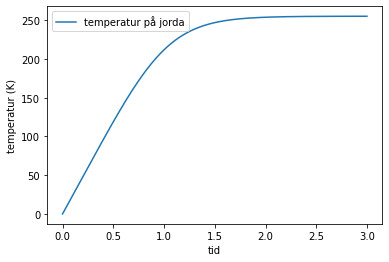

In [11]:
from pylab import *

surface_earth = 4 * pi * r_earth**2

S = energy_earth
A = surface_earth

t_list = [] # tid
T_list = [] # temperatur

def T_dot(T):
    return (S - A * sigma * T**4) / A

# Euler's metode:
dt = 1e-3
t_max = 3
T = 0
for t in arange(0, t_max, dt):
    T += T_dot(T) * dt
    
    t_list.append(t)
    T_list.append(T)

plot(t_list, T_list, label='temperatur på jorda')
legend()
xlabel('tid')
ylabel('temperatur (K)')
T_in_C = T_list[-1] - 273.15
print(f'sluttemperatur: {T_in_C} grader C')

Her kan vi se at temperaturen øker linært fram til jorda blir varm nok til å gi fra seg like mye stråling som den får av sola. Det er her grafen flater seg ut. Og da fikk den en sluttemperatur på ca. $-18,2^{\circ} C$

Men gjennomsnittstemperaturen på jorda er hvertfall ikke -18 grader! Og dette er antagelig på grunn av noen ganske grove antagelser vi har gjordt fram til nå. Diff. ligningen vår antar at:
- jorda er en perfekt sirkel, i perfekt vakum
- jorda ikke har noen atmotsfære
- jorda ikke blir varmet opp av sin egen kjerne
- jorda ikke har volum

## På tide å modellere en atmotsfære

Så la oss nå forsøke å modellere en atmotsfære. Først vil jeg understreke noen antagelser jeg gjør:
- All stråling fra sola går rett gjennom atmotsfæren
- All stråling fra jorda treffer atmotsfæren
- Halvparten av strålingen fra atmotsfæren treffer jorda
- Atmotsfæren ikke har volum, og har lik areal som jorda

Vi skal gjøre det samme som vi gjorde i modellen før, men nå må vi også holde styr på temperaturen i atmotsfæren og vi får derfor 2 diff. ligninger som sammen forklarer situasjonen. Først, temperaturen i atmotsfæren: Atmotsfæren får energi av strålingen fra jorda, samtidig som at den gir fra stråling. Dette kan representeres av diff. ligningen

$$
\dot E_a = A(\sigma T_j^4 - \sigma T_a^4)
$$
der:
- $E_a$ er varmeenergien i atmotsfæren
- $T_j$ er temperaturen på jorda
- $T_a$ er temperaturen i atmotsfæren
- $A$ er overflatearealet til jorda
- $\sigma = 5.6703*10^{-8}$

La oss omformulere ligningen til å finne $\dot T_a$ ved samme argument som ved forrige gang:

$$
\dot T_a = \sigma T_j^4 - \sigma T_a^4
$$

Nå, la oss finne en diff. ligning for temperaturen på jorda:
- Jorda får energi fra varmestrålingen fra sola
- Jorda får energi fra strålingen til atmotsfæren. Her antar jeg at halvparten av strålingen som atmotsfæren sender ut, treffer jorda, mens resten går til verdensrommet
- Jorda gir fra sin egen varmestråling
Dette kan representeres med følgende diff. ligning:
$$
\dot E_j = S + A 0.5 \sigma T_a^4 - A \sigma T_j^4
$$

La oss omformulere ligningen til å finne $\dot T_j$ ved samme argument som ved forrige gang:

$$
\dot T_j = \frac{S}{A} + 0.5 \sigma T_a^4 - \sigma T_j^4
$$

Videre, vi kan nå (endelig) bruke Euler's metode for å estimere hva temperaturen til jorda og atmotsfæren blir etter at solen har varmet dem opp i en stund.

sluttemperaturen på jorda er 29.752319146825528 grader C


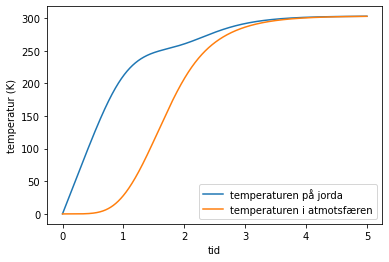

In [12]:
from pylab import *

S = energy_earth_given_radiation(radiation_earth)
A = surface_earth

t_list = []   # tid
T_j_list = [] # jordas temperatur
T_a_list = [] # atmotsfærens temperatur

def T_j_dot(T_j, T_a):
    return (S / A) + 0.5 * sigma * T_a**4 - sigma * T_j**4

def T_a_dot(T_j, T_a):
    return sigma * T_j**4 - sigma * T_a**4

# Eurler's metode:
dt = 1e-3
t_max = 5
T_j = 0
T_a = 0
for t in arange(0, t_max, dt):
    T_j += T_j_dot(T_j, T_a) * dt
    T_a += T_a_dot(T_j, T_a) * dt
    
    t_list.append(t)
    T_j_list.append(T_j)
    T_a_list.append(T_a)

plot(t_list, T_j_list, label='temperaturen på jorda')
plot(t_list, T_a_list, label='temperaturen i atmotsfæren')

legend()
xlabel('tid')
ylabel('temperatur (K)')

T_in_C = T_j_list[-1] - 273.15
print(f'sluttemperaturen på jorda er {T_in_C} grader C')

Her kan vi se at sola varmer opp jorda og atmotsfæren til de etter hvert blir ca. $29,8^{\circ} C$. Dette er ikke nøyaktig lik den måte gjennomsnittstemperaturen som er ca. $15^{\circ} C$, men vi nærmer oss.

Grunnen til at modellen ikke stemmer med virkeligheten er på grunn av noen sentrale antagelser vi har gjordt. Som at all stråling fra sola på jorda ikke samhandler med atmotsfæren på noen som helst måte. Og at temperaturen er lik over hele jorda og atmotsfæren. Og at atmotsfæren ikke har tykkelse. Eller at halvparten av strålingen fra atmotsfæren treffer jorda, mest sansynlig treffer antagelig rundt 30-40 % på grunn av atmotsfærens høyde over overflaten på jorda, og på grunn av refleksjon osv.

## En bedre atmotsfære (forhåpentlig vis)

La oss modifisere modellen slik at vi tar i betraktning at solstrålene absorsberes av atmotsfæren før de treffer jorda. La oss først bestemme en vilkårlig konstant $\beta$ som bestemmer hvor mye strålingen som treffer jorda fra sola, som er igjen etter at noe er blitt absorbert av atmotsfæren. Altså, om $\beta = 0$, blir all stråling absorbert av atmotsfæren, og ingenting treffer jorda. Mens om $\beta = 1$, ville all stråling gå rett gjennom atmotsfæren før de treffer jorda. Dette får vi til ved å multiplisere $\frac{S}{A}$ leddet med $\beta$ i diff. ligningen for jorda, mens vi adderer $\frac{S}{A} (1 - \beta)$ i diff. ligningen til atmotsfæren.

Da får vi to nye diff. ligninger

$$
\dot T_j = \frac{S}{A} \beta + 0.5 \sigma T_a^4 - \sigma T_j^4
$$

$$
\dot T_a = \frac{S}{A} (1 - \beta) + \sigma T_j^4 - \sigma T_a^4
$$

La oss løse disse ved Euler's metode, slik vi har gjordt tidligere.

temperaturen på jorden: 15.317459964555667 grader C


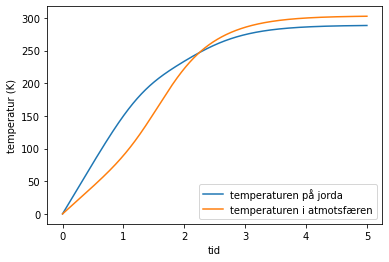

In [13]:
from pylab import *

def temp_earth_given_S(S, should_plot=True):
    A = surface_earth
    beta = 0.65

    t_list = []   # tid
    T_j_list = [] # jordas temperatur
    T_a_list = [] # atmotsfærens temperatur

    def T_j_dot(T_j, T_a):
        return (S / A) * beta + 0.5 * sigma * T_a**4 - sigma * T_j**4

    def T_a_dot(T_j, T_a):
        return (S / A) * (1 - beta) + sigma * T_j**4 - sigma * T_a**4

    # Euler's metode
    dt = 1e-3
    t_max = 5
    T_j = 0
    T_a = 0
    for t in arange(0, t_max, dt):
        T_j += T_j_dot(T_j, T_a) * dt
        T_a += T_a_dot(T_j, T_a) * dt

        t_list.append(t)
        T_j_list.append(T_j)
        T_a_list.append(T_a)

    if (should_plot):
        plot(t_list, T_j_list, label='temperaturen på jorda')
        plot(t_list, T_a_list, label='temperaturen i atmotsfæren')

        legend()
        xlabel('tid')
        ylabel('temperatur (K)')
    return T_j_list[-1]

S = energy_earth_given_radiation(radiation_earth)
avg_temp_earth = temp_earth_given_S(S)
temp_in_C = avg_temp_earth - 273.15
print(f'temperaturen på jorden: {temp_in_C} grader C')

Vi får en temperatur på $15.3^{\circ} C$ med denne modellen, det er ganske nærme den målte temperaturen på jorda! Betyr det at jeg har laget en bra modell? Nei. Og det er på grunn av at jeg valgte $\beta$ til å være $0.65$, en verdi jeg prøve meg fram til slik at sluttemperaturen ble ca. $15^{\circ} C$. Men vi kan allikavel lære noe nytt ved bruk av grafen. Vi ser at atmotsfæren ender opp med en sluttemperatur som er litt mer enn temperaturen på jorda. Dette gir mening, ettersom at atmotsfæren får varmestråling fra sola som derfor ikke treffer jorda. Dette fører til at jorda ender opp med en litt mindre temperatur.

## Temperaturen i Norge

Men nå som vi har en modell for gjennomsnittstemperaturen over hele jorda, la oss nå prøve å moddellere temperaturen i Norge over et helt år. Det er mye som skal til for å få til dette, og jeg vil ta i betraktning så mye som mulig.

### Jordas endrende distanse fra sola

Det er mulig å gjøre dette på en ganske god måte ved å simulere solas gravitasjon på jorda over et helt år for å se hvor langt unna jorda er for hver dag. Men jeg velger å heller bruke en forenklet modell: ved bruk av en cosinus bølge. Jeg velger å anta at jordas distanse fra sola kan svinger likt som en cosinus bølge. Eller mer konkret, at:
$$
r = - d \cos(2 \pi \frac{c}{365}) + a
$$

der:
- $r$ er distansen mellom jorda og sola
- $a$ er gjennomsnittsdistansen fra jorda og sola, semi-major axis
- $d$ er differansen mellom det $a$ og den lengste mulige distansen mellom jorda og sola
- $c$ er antall dager etter første januar.

$a$ regnes ut ved
$$
a = \frac{(a_p + p_{er})}{2}
$$
der:
- $a_p$ er apoapsis, den lengste mulige distansen mellom jorda og sola
- $p_{er}$ er periapsis, den korteste mulige distansen mellom jorda og sola

mens $d$ kan regnes ut ved:
$$
d = a_p - a
$$

Jeg velger å bruke denne modellen fordi den er enkel og har noen grunnlegende egenskaper som alle modeller som modellerer distansen mellom jorda og sola bør ha. Nemlig at:
- den repiterer seg etter 365 dager
- den er kontenuerlig
- den varierer fra $p_{er}$ til $a_p$

Så selv om den åpenbart ikke er perfekt, så er den nærme nok (tenker jeg).

### Norges breddegrad og jordas "vippe"

Grunnen til at Norge har årstider er på grunn av at Norge ligger betraktlig nord for ekvator og fordi jorda roterer skrått i forhold til dens bane rundt sola. Dette gjør at solstrålene treffer Norge på en vinkel som varierer i løpet av året. Dette vil jeg få med i den avsluttende modellen. Måten jeg vil modellere dette på, er ved nok en trigometrisk funskjon:

$$
S = \cos(lat_{new}) E
$$

der:
- $S$ er den totale energien Norge får av sola, per sekund. Den er naturligvis propersjonal med energien som hele jorda får ($E$)
- $E$ er den totale energien som jorda får av sola, per sekund. Vi bruker en tidligere definert funskjon til å finne denne (i koden: energy_earth_given_radiation())
- $lat_{new}$ er vinkelen som Norge får med punktet på jorda der strålingen fra sola treffes normalt på bakken.

$E$ er ganske grei å finne, ettersom at vi kan bruke en tidligere definert funskjon.

Men for å finne $lat_{new}$, bruker vi denne formelen

$$
lat_{new} = t \cos(2 \pi \frac{c}{365}) + lat
$$

der:
- $t$ er jordas "vippe", ca. $23.5^{circ}$
- $c$ er antall dager etter 1. Januar.
- $lat$ er Norges breddegrad: ca. $59,9^{\circ}$

Er dette en god modell for vinkelen som Norge får med punktet på jorda der strålingen fra sola treffer normalt? Kanskje. Jeg har ikke gått grundig gjennom hvordan geometrien til systemet fungerer, men noen viktige egenskaper som en slik modell må ha:
- den repiteres etter 365 dager
- den går øker og minker propesjonal med vippe-vinkelen til jorda
- den starter med høy vinkel (fordi i Januar er det kaldest) og slutter med høy vinkel, med lav vinkel om sommeren

### Diffusjon

Antageligvis ville nok temperaturen til Norge bli påvirket av temperaturen til resten av planeten. Jeg velger å moddellere dette ved å si at Norges temperatur er et vekta gjennomsnitt mellom temperaturen som Norge eller hadde hatt, og den gjennomsnittlige temperaturen til jorda. Dette kan man skrive som:

$$
T_{diffused} = T (1 - \gamma) + T_{avg} \gamma
$$
der:
- $T_{diffused}$ er temperaturen i Norge, etter diffusjon
- $T$ er temperaturen i Norge, før diffusjon
- $T_{avg}$ er den gjennomsnittlige temperaturen på jorda (i koden: avg_temp_earth)
- $\gamma$ er et vilkårlig tall som besrkiver hvor mye vekt $T_{avg}$ skal ha. Med andre ord, hvor mye temperaturen skal "deffusere"

$T$ finner vi ved en funskjon vi har definert tidligere, her setter vi S (som vi har regnet ut over) som parameter.

$\gamma$ er et vilkårlig tall som jeg satt lik $0,8$

Er dette en presis måte å moddellere diffusjon? Nei. Temperaturen på jorda blir fordelt via vinn, hav og mye mer som er veldig vanskelig å modellere. Men et enkelt vekta gjennomsnitt bør gi oss gode resultater allikavel.

### La oss sette alt sammen i koden

Temperaturen i Norge i løpet av et år 🦄: min: -24.475815633430074 grader C, max: 11.512715688091589 grader C


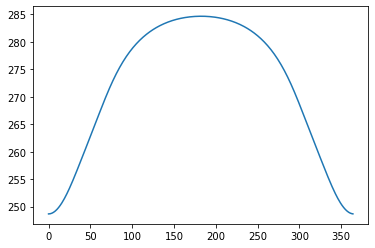

In [14]:
from math import sin

temps = []
year = range(365)

ap = 152_098_233e3  # apoapsis
per = 147_098_291e3 # periapsis
a = (ap + per) / 2  # semi-major axis
diff = ap - a

latitude = 59.8562209 * pi / 180
earth_tilt = 23.5 * pi / 180

gamma = 0.8

for day in year:
    # jordas endrende distanse til sola
    theta = 2 * pi * day / len(year)
    dist = - diff * cos(theta) + a
    radiation = radiation_earth_given_dist(dist)

    # Norge's endrende vinkel til solstrålene
    E = energy_earth_given_radiation(radiation)
    lat_new = earth_tilt * cos(theta) + latitude
    S = cos(lat_new) * E

    # diffusjon
    T = temp_earth_given_S(S, should_plot=False)
    T_diffused = T * (1 - gamma) + avg_temp_earth * gamma

    temps.append(T_diffused)

plot(year, temps)

min_temp = min(temps) - 273.15
max_temp = max(temps) - 273.15
print(f'Temperaturen i Norge i løpet av et år 🦄: min: {min_temp} grader C, max: {max_temp} grader C')

Her kan vi se at modellen gir oss $-24,5^{\circ}C$ i januar og desember, mens vi får ca. $11,5^{\circ}C$ mens mesteparten av temperaturen ser ut til å være plussgrader. La oss sammenligne det med temperaturene i Oslo over 2019 ifølge yr.no
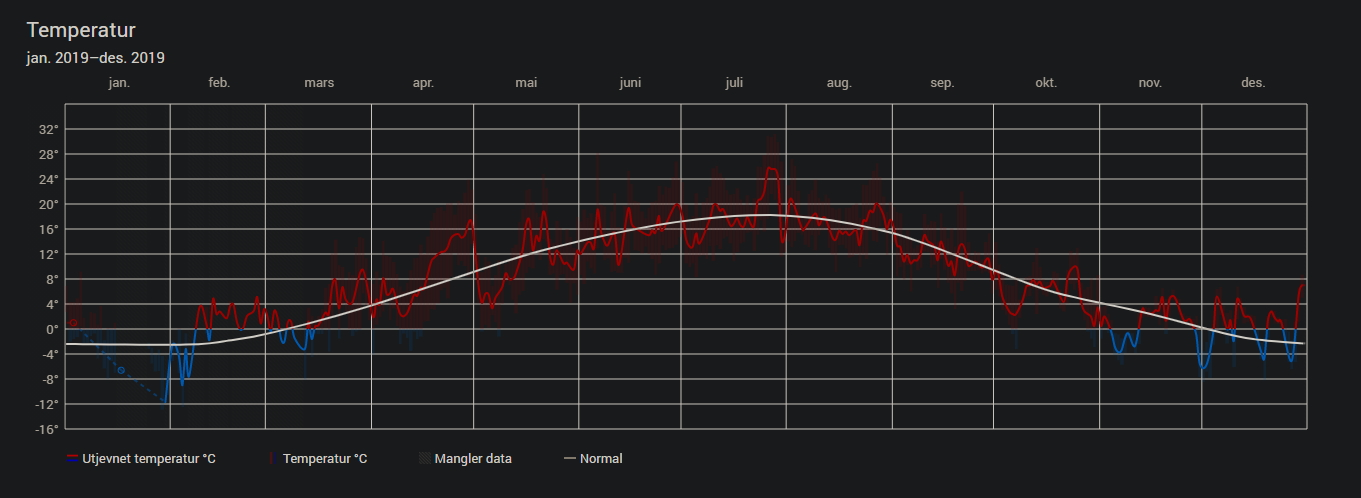
Her ser vi at selve formen på kurvene ligner ganske mye. Men de faktiske temperaturene er ganske langt fra hverandre. Hva kan være noen grunner til dette? Det er nok fordi modellen min kun er en forenklet versjon av virkeligheten, hvor jeg ikke har tatt inn i betrakning alle de hundrevis av andre faktorene som bestemmer temperaturen på forskjellige steder på jorda.

## Konklusjon

Jeg er ganske fornøyd med modellen vi endte opp med, selv om den ikke er perfekt. Jeg har gjordt utrolig mange forenklinger, som at:
- temperatur blir diffusert som om temperaturen var et vekta gjennomsnitt
- vi ikke har tatt hensyn til vind, goldstrømmen, coriolis effekten, eller alle andre hundrevis av værfenomener som påvirker temperaturen
- distansen mellom jorda og sola modelleres som en cosinus bølge
- vinkelen som Norge danner med solstrålene modelleres som en cosinus bølge
- alle andre forenklinger og antagelser vi har gjordt tidligere i oppgaven

Det bokstavelig talt umulig å lage en perfekt modell for været på jorda på grunn av været er såpass kaotisk og alle variablene er utrolig sensetive. Det er derfor værmeldingen er ganske ofte feil, og det er derfor det er nærmest umulig for meg å svare ordentlig godt på oppgaven.